# Milestone Project 1 : Food Vision Big

Check GPU usage

To get information about mixed precision visit : https://www.tensorflow.org/guide/mixed_precision

If we want to implement mixed precision, we should have a GPU that has at least 7.0 computation capability

Thanks to Google in Colab Tesla T4 has 7.4 compute capability

* Google Colab offers free GPUs. However, not all of them are compatible with mixed precision training.

* Google Colab offers:
1. K80 (not compatible)
2. P100 (not compatible)
3. Tesla T4 (compatible)

Knowing this, in order to use mixed precision training we need to acces to a Tesla T4 (from within google colab)


In [1]:
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-281f5237-6359-cdb8-f3ae-871172d4e64e)


## Get helper functions

In past modules, we have created a bunch of helper functions to do small tasks required for our notebooks. Rather than rewrite all of these, we can import a script and load them in from there.

The script we have got available can be found on github.


In [2]:
# Download helper functions script
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2023-09-06 19:25:22--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.111.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2023-09-06 19:25:23 (60.7 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [3]:
# Import series of helper functions for the notebook
from helper_functions import walk_through_dir, plot_loss_curves, create_tensorboard_callback, compare_historys

# Use TensorFlow Datasets to Download Data

If you want to get an overview of Tensorflow datasets (TFDS) read the guide : https://www.tensorflow.org/datasets/api_docs/python/tfds

In [4]:
# Get TensorFlow Datasets
import tensorflow_datasets as tfds

In [5]:
# List all available datasets
datasets_list = tfds.list_builders() # get all available datasets in TFDS
print("food101" in datasets_list) # is our target dataset

True


In [19]:
# Load in the data (takes 5-6 minutes in Google Colab)
(train_data, test_data), ds_info = tfds.load(name="food101",
                                             split=["train","validation"],
                                             shuffle_files=True,
                                             as_supervised=True, # data gets returned in tuple format (data,label)
                                             with_info=True
                                             )

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/75750 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/food101/2.0.0.incompleteF4RPRQ/food101-train.tfrecord*...:   0%|          …

Generating validation examples...:   0%|          | 0/25250 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/food101/2.0.0.incompleteF4RPRQ/food101-validation.tfrecord*...:   0%|     …

Dataset food101 downloaded and prepared to /root/tensorflow_datasets/food101/2.0.0. Subsequent calls will reuse this data.


## Exploring the Food101 data from TensorFlow Datasets

To become one with the data, we want to find:

* Class names
* The shape of our input data (image tensor)
* The datatype of our input data
* What the labels look like (e.g. are they one-hot encoded or are they label encoded)
* Do the labels match up with the class name?

In [20]:
# Features of Food101 from TFDS
ds_info.features

FeaturesDict({
    'image': Image(shape=(None, None, 3), dtype=uint8),
    'label': ClassLabel(shape=(), dtype=int64, num_classes=101),
})

In [21]:
# Get the class names
class_names = ds_info.features["label"].names
class_names[:10]

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito']

In [22]:
# Take one sample of the train data
train_one_sample = train_data.take(1) # samples are in format (image_tensor, label)

In [23]:
# What does one sample of our training data look like
train_one_sample

<_TakeDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

In [24]:
# Output info about our training sample
for image,label in train_one_sample:
  print(f"""
  Image shape : {image.shape}
  Image data type : {image.dtype}
  Target class from Food101 (tensor form) : {label}
  Class name (str form): {class_names[label.numpy()]}
  """)


  Image shape : (512, 512, 3)
  Image data type : <dtype: 'uint8'>
  Target class from Food101 (tensor form) : 56
  Class name (str form): huevos_rancheros
  


In [26]:
# What does our image tensor from TFDS'S Food101 look like ?
image

<tf.Tensor: shape=(512, 512, 3), dtype=uint8, numpy=
array([[[233, 253, 251],
        [231, 253, 250],
        [228, 254, 251],
        ...,
        [ 85,  82,  89],
        [ 68,  67,  75],
        [ 57,  57,  67]],

       [[232, 254, 252],
        [229, 254, 251],
        [226, 255, 251],
        ...,
        [121, 116, 120],
        [100,  99, 104],
        [ 86,  85,  91]],

       [[228, 254, 253],
        [226, 255, 253],
        [223, 255, 252],
        ...,
        [164, 159, 155],
        [145, 141, 138],
        [128, 127, 125]],

       ...,

       [[ 66, 112, 164],
        [ 67, 113, 163],
        [ 55,  99, 148],
        ...,
        [  5,  14,  23],
        [  9,  18,  27],
        [  8,  17,  26]],

       [[ 76, 123, 177],
        [ 75, 122, 176],
        [ 70, 116, 168],
        ...,
        [  5,  14,  23],
        [  9,  18,  25],
        [  7,  16,  23]],

       [[ 80, 129, 185],
        [ 71, 121, 174],
        [ 74, 121, 175],
        ...,
        [  7,  16,  2

In [27]:
# What are  the min and max values of our image tensor ?
import tensorflow as tf
tf.reduce_min(image), tf.reduce_max(image)

(<tf.Tensor: shape=(), dtype=uint8, numpy=0>,
 <tf.Tensor: shape=(), dtype=uint8, numpy=255>)

## Plot an image from TensorFlow Datasets

(-0.5, 511.5, 511.5, -0.5)

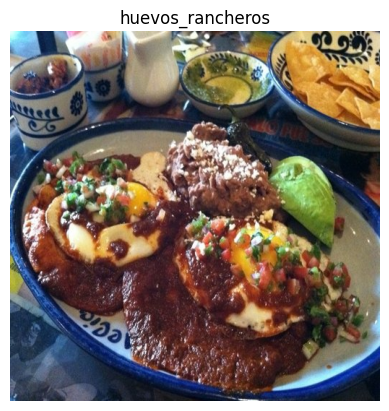

In [28]:
# Plot an image tensor
import matplotlib.pyplot as plt
plt.imshow(image/255)
plt.title(class_names[label.numpy()])
plt.axis(False)

## Create preprocessing functions for our data

Neural networks perform best when data is in a certain way (e.g. batched, normalized, etc)

However, not all data (including data from tensorflow datasets ) comes like this

Therefore, in order to get it ready for a neural network you will often have to write preprocessing functions and mao it to your data


What we know about our data:
* In 'uint8' datatype
* Comprised of all different size tensors (different sized images)
* Not scaled (the pixel values are between 0 & 255)

What we know models like:
* Data in 'float32' dtype (or for mixed precision 'float16' and 'float32')
* For batches, TensorFlow likes all of the tensors within a batch to be of the same size
* Scaled (values between 0 & 1) also called as normalized tensors generally perform better

With these points in mind, we have got a few things we can tackle with a preprocessing function.

Since we are going to be used an EfficienNetBX pretrained model from tf.keras.applications we do not need to rescale our data (these architectures have rescaling built-in)

This means our functions needs to:
1. Reshape our images to all the same size
2. Convert the dtype of our image tensors from 'uint8' to 'float32'

In [30]:
# Make a function for preprocessing images
def preprocess_img (image,label,img_shape=224):
  """
  Converts image datatype from uint8 -> float32 and reshapes
  image to [img_shape,img_shape,color_channels]
  """
  image = tf.image.resize(image, [img_shape,img_shape]) # reshape the target image
  # image = image/255 # scale image values (not required with efficientNetBX)
  return tf.cast(image,tf.float32), label # return (float32_image,label) tuple

In [31]:
# Preprocess a single sample image and check the outputs
preprocessed_img = preprocess_img(image,label)[0]
print(f"Image before preprocessing:\n  {image[:2]}....., \nShape: {image.shape}, \nDatatype: {image.dtype}\n")
print(f"Image after preprocessing:\n  {preprocessed_img[:2]}....., \nShape: {preprocessed_img.shape}, \nDatatype: {preprocessed_img.dtype}\n")


Image before preprocessing:
  [[[233 253 251]
  [231 253 250]
  [228 254 251]
  ...
  [ 85  82  89]
  [ 68  67  75]
  [ 57  57  67]]

 [[232 254 252]
  [229 254 251]
  [226 255 251]
  ...
  [121 116 120]
  [100  99 104]
  [ 86  85  91]]]....., 
Shape: (512, 512, 3), 
Datatype: <dtype: 'uint8'>

Image after preprocessing:
  [[[230.65816 253.64285 251.     ]
  [222.99998 254.97449 252.19388]
  [207.06633 255.      250.36734]
  ...
  [140.66287 129.52519 121.22428]
  [121.14268 115.26515 116.95397]
  [ 83.95363  83.08119  89.63737]]

 [[221.47449 254.37755 253.33163]
  [214.5102  255.      253.92348]
  [198.41327 254.58673 251.96939]
  ...
  [208.66318 195.82143 173.40823]
  [197.03056 190.1071  174.83162]
  [175.54036 171.6169  161.21384]]]....., 
Shape: (224, 224, 3), 
Datatype: <dtype: 'float32'>



## Batch & prepare datasets

We are going to make our data input pipline run really fast.

In [32]:
# Map preprocessing function to training (and parallelize)
train_data = train_data.map(map_func=preprocess_img, num_parallel_calls=tf.data.AUTOTUNE)

# Shuffle train_data and turn it into batches and prefetch it (load it faster)
train_data = train_data.shuffle(buffer_size=1000).batch(batch_size=32).prefetch(buffer_size=tf.data.AUTOTUNE)

# Map preprocessing functions to test data
test_data = test_data.map(map_func=preprocess_img, num_parallel_calls=tf.data.AUTOTUNE)

# Turn test data into batches (don't need to shuffle)
test_data = test_data.batch(32).prefetch(tf.data.AUTOTUNE)



In [33]:
train_data,test_data

(<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>,
 <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>)

"Hey tensorflow, map this preprocessing function {'preprocess_img'} across our training dataset, then shuffle a number of elements and then batch them together and finally make sure you prepare new batches (prefetch) whilst the model is looking through (finding patterns) the current batch."

## Create modelling callbacks

We are going to create a cuple of callbacks to help us while our model trains:

* Tensorboard callback to log training results (so we can visualize them later if need be)
* ModelCheckPoint callback to save our model's progress after feature extraction

In [35]:
# Create tensorboard callback (import from helper_functions.py)
from helper_functions import create_tensorboard_callback

# Create a ModelCheckPoint callback to save a model's progress during training
checkpoint_path = "model_checkpoint/cp.ckpt"
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                      monitor="val_acc",
                                                      save_best_only=True,
                                                      save_weights_only=True,
                                                      verbose=0 # do not print whether or not model is being saved
                                                      )

In [34]:
# Downgrade Tensorflow Version (run this in Google Colab)
# !pip install tensorflow==2.4.1

## Setup Mixed Precision Training

Mixed Precision utlizes a combination of float32 and float16 data types for speed up model performance

**NOTE :** Mixed precision training uses the combination of float32 and float16 data types to speed up model training (can result in a 3x speed up on modern GPU's)

In [36]:
# Turn on mixed precision training
from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy("mixed_float16") # set gloabş data policy to mixed precision

In [37]:
!nvidia-smi

Wed Sep  6 19:46:21 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   74C    P0    33W /  70W |    449MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [38]:
mixed_precision.global_policy()

<Policy "mixed_float16">

## Build the Feature Extraction Model


In [ ]:
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing

# Create the base model
input_shape=(224,224,3)
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable=False

# Create functional model
inputs=layers.Input(shape=input_shape,name="Input_layer") # to prevent error expand_dims is used
# Note : efficientNetBX models have rescaling buit-in but if your does not have you can have a layer like below
# x = preprocessing.Rescaling(1./255)(x)
# or you can change the preprocess_img function to rescale the img
x = base_model(inputs,training=False) # make sure layers which should be in inference mode only stay like that
x = layers.GlobalAveragePooling2D(name="global_pooling_layer")(x)
x = layers.Dense(len(class_names))(x)
outputs = layers.Activation(activation="softmax", dtype = tf.float32, name="softmax_float32")(x)
model = tf.keras.Model(inputs,outputs)

# Compile the model
model.compile(loss = "sparse_categorical_crossentropy",# because our labels are in form of integer we need to sparse them
              optimizer = tf.keras.optimizers.Adam(),
              metrics=["accuracy"]
              )


In [ ]:
model.summary()

## Checking layer dtype policies (are we using mixed precision)

In [ ]:
# Check the dtype....-policy attributes of layers in our model
for layer in model.layers:
  print(layer.name, layer.trainable, layer.dtype, layer.dtype_policy)

Going through the above we have seen:
* 'layer.name ': the human readable name of a particular layer
*  'layer.trainable': is the layer trainable or not ? (if *false* weights are frozen)
* 'layer.dtype': the datatype a layer stores its variables in
* 'layer.dtype': the data type policy a layer computes on its variables with

In [ ]:
# Check the dtype_policy attribute in base_model
for layer in model.layers[1].layers[:20]:
  print(layer.name, layer.trainable, layer.dtype, layer.dtype_policy)

## Fit the feature extractor model

If our goal is to fine-tune a pretrained model, the general order of doing things is:
1. Build a feature extraction model (train a couple output layers with base layers frozen).
2. Fine-tune some of the frozen layers


In [ ]:
# Fit the feature extraction model with callbacks
history = model.fit(train_data,
                    epochs=3,
                    steps_per_epoch=len(train_data),
                    validation_data=test_data,
                    validation_steps = int(0.15 * len(test_data)),
                    callbacks = [create_tensorboard_callback(dir_name="training_logs",
                                                             experiment_name="efficientnetb0_feature_extractor"),
                                 model_checkpoint
                                 ]
                    )

In [ ]:
# Evaluate model on whole test dataset
feature_extraction_results = model.evaluate(test_data)

In [ ]:
# let see the plots
from helper_functions import plot_loss_curves
plot_loss_curves(history)

In [ ]:
# Check the layers in the base model and see what dtype policy they're using
for layer in base_model.layers:
  print(layer.name, layer.dtype_policy)

## Preparing our model's layers for fine-tuning

**Next :** Fine-tune the feature extraction model to beat the DeepFood paper.

In [ ]:
# Download the saved model from Google Storage
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/07_efficientnetb0_feature_extract_model_mixed_precision.zip

In [ ]:
# Unzip the SavedModel downloaded from Google Stroage
!mkdir downloaded_gs_model # create new dir to store downloaded feature extraction model
!unzip 07_efficientnetb0_feature_extract_model_mixed_precision.zip -d downloaded_gs_model

In [ ]:
# Load and evaluate downloaded GS model
model = tf.keras.models.load_model("/content/downloaded_gs_model/07_efficientnetb0_feature_extract_model_mixed_precision")

In [ ]:
# evaluate downloaded GS model
model.evaluate(test_data)

In [ ]:
# Get a summary of the downloaded model
model.summary()

In [ ]:
# See the layers of our model
for layer in model.layers:
  print(layer.name, layer.trainable)

In [ ]:
# Set all of the layers .trainable variable in the loaded model to True (so they're unfrozen)
base_model = model.layers[1]
base_model.trainable = True

In [ ]:
# See the layers of our model again
for layer in model.layers:
  print(layer.name, layer.trainable)

In [ ]:
# make last 10 unfrozen but the other layers should be remain frozen for fine-tuning
for layer in base_model.layers[:-10]:
  layer.trainable = False

In [ ]:
# See the base model layers
for layer in base_model.layers:
  print(layer.name, layer.trainable)

In [ ]:
# Check to see what dtype_policy of the layers in your loaded model are
for layer in model.layers:
  print(layer.name, layer.dtype_policy)

In [ ]:

# Setup EarlyStopping callback to stop training if model's val_loss doesn't improve for 3 epochs
# Monitor the val_loss and stop training if it doesn't improve for 3 epochs
# See: https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/EarlyStopping for more
early_stopping_callback = tf.keras.callbacks.EarlyStopping(monitor = "val_loss",
                                                           patience = 3,
                                                           )

# Create ModelCheckpoint callback to save best model during fine-tuning
# Save the best model only
# Monitor val_loss while training and save the best model (lowest val_loss)
# See: https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/ModelCheckpoint for more
checkpoint_path = "model_checkpoint.ckpt"
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath =checkpoint_path,
                                                      monitor = "val_loss",
                                                      save_best_only = True,
                                                      save_weights_only=True,
                                                      )

# Creating learning rate reduction callback
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss",
                                                 factor=0.2, # multiply the learning rate by 0.2 (reduce by 5x)
                                                 patience=2,
                                                 verbose=1, # print out when learning rate goes down
                                                 min_lr=1e-7)

In [ ]:
# Compile the model ready for fine-tuning
# Use the Adam optimizer with a 10x lower than default learning rate
model.compile(loss = "sparse_categorical_crossentropy",
              optimizer = tf.keras.optimizers.Adam(0.0001), # 10x lower learning rate than the default
              metrics = ["accuracy"]
              )

In [ ]:
# Start to fine-tune (all layers)
model.trainable = True # includes base_model

In [ ]:
# Use 100 epochs as the default
# Validate on 15% of the test_data
# Use the create_tensorboard_callback, ModelCheckpoint and EarlyStopping callbacks you created eaelier
histor_1 = model.fit(train_data,
                     epochs=100,
                     steps_per_epoch=len(train_data),
                     validation_data = test_data,
                     validation_steps = int(0.15 * len(test_data)),
                     callbacks = [create_tensorboard_callback(dir_name="training_logs",
                                                              experiment_name = "efficientnetb0_fine_tuning"),
                                    model_checkpoint, early_stopping_callback, reduce_lr
                                  ]
                     )

In [ ]:
# Let's save this model for future usage
model.save("/content/drive/MyDrive/Saved_TensorFlow_Models/fine_tuning_food101.keras")

In [ ]:
# let's evaluate the model
fine_tuning_results = model.evaluate(test_data)

In [ ]:
loaded_model = tf.keras.models.load_model("/content/drive/MyDrive/Saved_TensorFlow_Models/fine_tuning_food101.keras")

In [ ]:
loaded_model_results = loaded_model.evaluate(test_data)

##Download fine-tuned model from Google Storage

It's a fine-tuned model exactly like the one we trained above but it's saved to Google Storage so it can be accessed, imported and evaluated.

In [ ]:
# Download and evaluate fine-tuned model from Google Storage
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/07_efficientnetb0_fine_tuned_101_classes_mixed_precision.zip

In [ ]:
# Unzip fine-tuned model
!mkdir downloaded_fine_tuned_gs_model # create separate directory for fine-tuned model downloaded from Google Storage
!unzip 07_efficientnetb0_fine_tuned_101_classes_mixed_precision -d downloaded_fine_tuned_gs_model

In [ ]:
gs_model = tf.keras.models.load_model("/content/downloaded_fine_tuned_gs_model/07_efficientnetb0_fine_tuned_101_classes_mixed_precision")

In [ ]:
# Get a model summary (same model architecture as above)
gs_model.summary()

In [ ]:
# Evaluate loaded model
results_fine_tuned_gs_model = gs_model.evaluate(test_data)
results_fine_tuned_gs_model


📖 Resource: To see which models are currently performing the best on a given dataset or problem type as well as the latest trending machine learning research, be sure to check out paperswithcode.com and sotabench.com.

Since we tracked our model's fine-tuning training logs using the TensorBoard callback, let's upload them and inspect them on TensorBoard.dev.

## View training results on TensorBoard

In [ ]:
!tensorboard dev upload --logdir ./training_logs \
   --name "Fine-tuning EfficientNetB0 on all Food101 Data" \
   --description "Training results for fine-tuning EfficientNetB0 on Food101 Data with learning rate 0.0001" \
   --one_shot

In [ ]:
# View past TensorBoard experiments
!tensorboard dev list

In [11]:
# let enjoy our model by making prediction
# Let's make a function to orediction  # improved upon helper functions
def pred_and_plot(model, filename, class_names):
  """
  Imports an image located at filename, makes a prediction on it with
  a trained model and plots the image with the predicted class as the title.
  """
  # Import the target image and preprocess it
  img = load_and_prep_image(filename,scale=False)

  # Make a prediction
  pred = model.predict(tf.expand_dims(img, axis=0))

  # Get the predicted class
  if len(pred[0]) > 1: # check for multi-class
    pred_class = class_names[pred.argmax()] # if more than one output, take the max
  else:
    pred_class = class_names[int(tf.round(pred)[0][0])] # if only one output, round

  # Plot the image and predicted class
  plt.imshow(img/255)
  plt.title(f"Prediction: {pred_class}")
  plt.axis(False);

  # Create a function to load and prepare images
def load_and_prep_image(filename, img_shape=224,scale=False):
  """
  Reads in an image from filename, turns it into a tensor and reshapes into specified shape
  (img_shape,img_shape,color_channels=3).

  Args:
    filename (str) : path to target image
    img_shape (int) : height/width dimension of the target image size
    scale (bool) : Scale pixel values from 0-255 to 0-1 or not

  Returns
    Image tensor of shape (img_shape,img_shape,3)
  """

  # Read in the image
  img = tf.io.read_file(filename=filename)

  # Decode image into a tensor
  img = tf.io.decode_image(img, channels=3)

  # Resize the image
  img = tf.image.resize(img,[img_shape,img_shape])

  # Scale? Yes/No
  if scale:
    # rescale the image (get all values betweem 0 & 1)
    return img/255.
  else:
    return img # don't need to rescale images for EfficientNet models in TensorFlow

In [12]:
# Let's upload some test data to make prediction
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/custom_food_images.zip

--2023-09-06 19:34:10--  https://storage.googleapis.com/ztm_tf_course/food_vision/custom_food_images.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.141.207, 142.251.2.207, 74.125.137.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.141.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13192985 (13M) [application/zip]
Saving to: ‘custom_food_images.zip’

custom_food_images. 100%[===================>]  12.58M  7.93MB/s    in 1.6s    

2023-09-06 19:34:12 (7.93 MB/s) - ‘custom_food_images.zip’ saved [13192985/13192985]



In [13]:
from helper_functions import unzip_data
unzip_data("/content/custom_food_images.zip")

In [15]:
# Because our runtime connection disconnected let's reload the model and make some predictions
model = tf.keras.models.load_model("/content/drive/MyDrive/Tensorflow_Machine_Learning/Saved_Models/fine_tuning_food101.keras")

In [64]:
import os
images = []
image_names=[]
for image in os.listdir("/content/custom_food_images"):
  image_names.append(image[:-5])
  image = "/content/custom_food_images/" + image
  images.append(image)
images.remove('/content/custom_food_images/.ipynb_checkpoints')
images

['/content/custom_food_images/steak.jpeg',
 '/content/custom_food_images/hamburger.jpeg',
 '/content/custom_food_images/ramen.jpeg',
 '/content/custom_food_images/chicken_wings.jpeg',
 '/content/custom_food_images/sushi.jpeg']

1/1 [==============================] - 0s 46ms/step


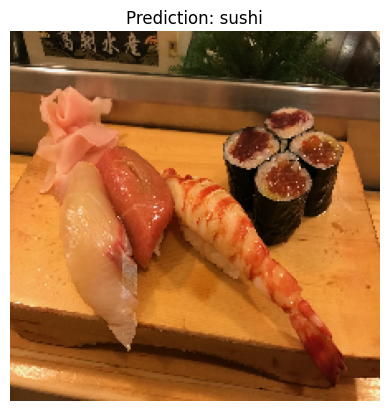

In [70]:
# Let's make predictions
for img in images:
  pred_and_plot(model, img, class_names)